In [1]:
import os

import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
import socket

import arccnet.models.cutouts_from_fulldisk.config as config
import arccnet.models.dataset_utils as ut_d
import arccnet.models.train_utils as ut_t
import arccnet.visualisation.utils as ut_v

from astropy.io import fits
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import timm

from arccnet.models import labels as lbs
import seaborn as sns

In [2]:
os.environ['HTTP_PROXY'] = 'http://proxy.unige.it:8080'
os.environ['HTTPS_PROXY'] = 'http://proxy.unige.it:8080'

In [3]:
# Load Dataset
base_dir = '/ARCAFF/data/cutouts_from_fulldisk/'
df = pd.read_parquet(os.path.join(base_dir, 'dataframe.parquet'))

label_mapping = {
    "Alpha": "Alpha",
    "Beta": "Beta",
    "Beta-Delta": "Beta",
    "Beta-Gamma": "Beta-Gamma",
    "Beta-Gamma-Delta": "Beta-Gamma",
    "Gamma": None,
    "Gamma-Delta": None,
}

df["grouped_labels"] = df["magnetic_class"].map(label_mapping)
df['Index'] = range(len(df))

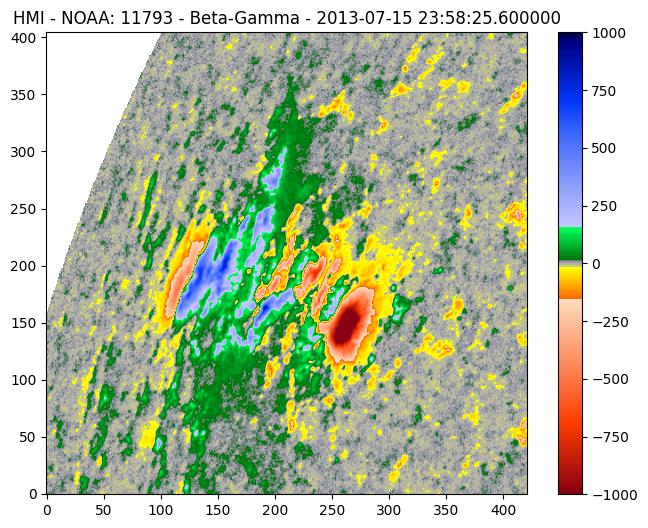

In [4]:
# Sample Entry
row = df.iloc[4563]
filename = (
    f"{row['instrument']}_{row['datetime'].strftime('%Y%m%d_%H%M%S')}_NOAA_{row['NOAA']}_{row['magnetic_class']}"
)

with fits.open(os.path.join(base_dir, 'fits', f'{filename}.fits')) as img_fit:
    data = img_fit[0].data
    header = img_fit[0].header
plt.figure(figsize = (8,6))
plt.imshow(data, origin='lower', cmap = ut_v.magnetic_map, vmin=-1000,vmax=1000)
plt.title(f"{row['instrument']} - NOAA: {row['NOAA']} - {row['magnetic_class']} - {row['datetime']}")
plt.colorbar()

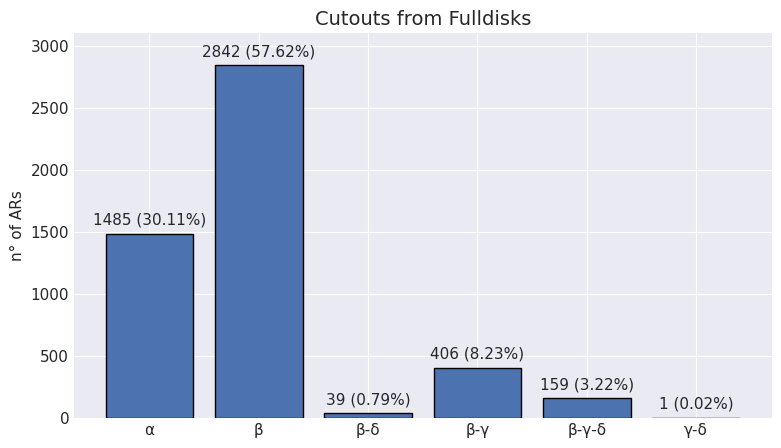

In [5]:
ut_v.make_classes_histogram(df['magnetic_class'], y_off = 50, ylim = 3100, figsz=(9, 5), title = 'Cutouts from Fulldisks')

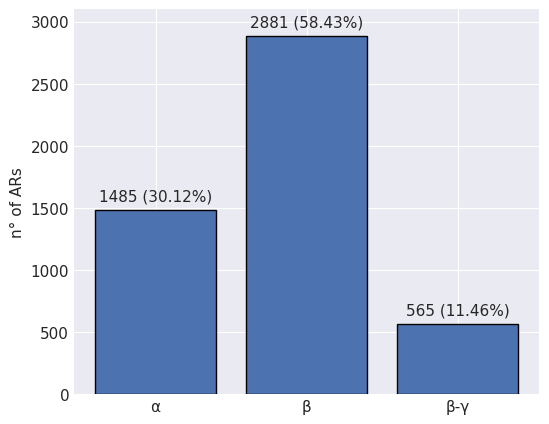

In [6]:
ut_v.make_classes_histogram(df['grouped_labels'], y_off = 50, ylim = 3100, figsz=(6, 5))

In [7]:
split_df = df.dropna(subset=["grouped_labels", "NOAA"]).copy()
fold_df = ut_d.split_data(split_df, label_col="grouped_labels", group_col="NOAA", random_state=42)
df_tr = ut_d.assign_fold_sets(df, fold_df)

labels = np.array(df_tr['grouped_labels'])
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
df_tr.loc[:, 'encoded_labels'] = encoded_labels
print("Labels Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Labels Mapping: {'Alpha': 0, 'Beta': 1, 'Beta-Gamma': 2, None: 3}


In [8]:
fold_n = 1

train_df = df_tr[df_tr[f'Fold {fold_n}']=='train']
val_df = df_tr[df_tr[f'Fold {fold_n}']=='val']
test_df = df_tr[df_tr[f'Fold {fold_n}']=='test']

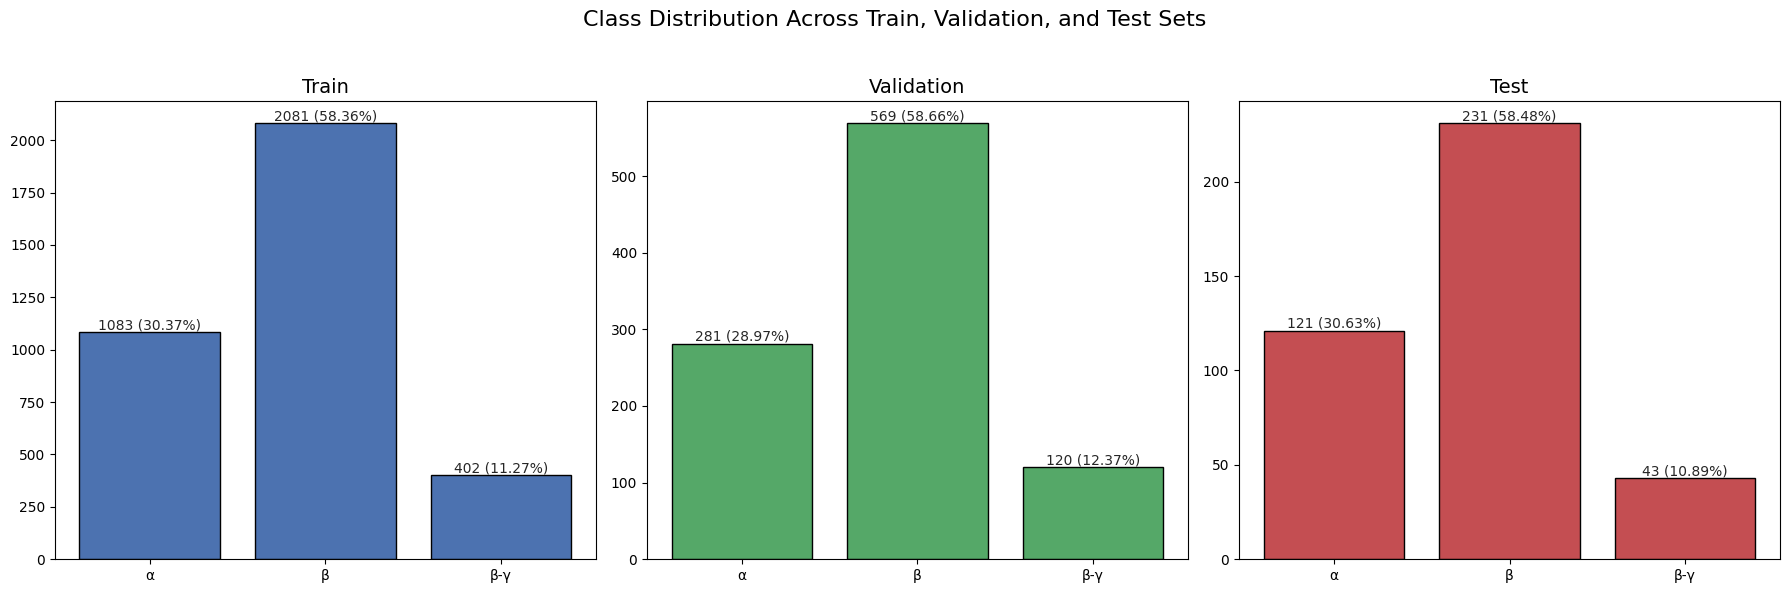

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # No shared y-axis

# Define subplot-specific titles and colors
titles = ["Train", "Validation", "Test"]
colors = ["#4C72B0", "#55A868", "#C44E52"]  # Different colors for each plot

# Iterate over dataframes and subplots
for ax, df_tmp, title, color in zip(axs, [train_df, val_df, test_df], titles, colors):
    ut_v.make_classes_histogram(
        df_tmp['grouped_labels'],
        y_off=0,  # Adjusted offset for better spacing
        title=title,
        bar_color=color,
        ax=ax,
        fontsize=10,
        text_fontsize=10,
    )

# Add a common main title
fig.suptitle("Class Distribution Across Train, Validation, and Test Sets", fontsize=16)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()


In [ ]:
df

,target_time.jd1,target_time.jd2,datetime.jd1,datetime.jd2,instrument,path,processed_path_image,target_time_arc.jd1,target_time_arc.jd2,datetime_arc.jd1,...,width,height,grouped_labels,Index,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,encoded_labels
30,2450262.0,0.5,2450263.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450262.0,0.5,2450263.0,...,0.108398,0.062500,Alpha,0,train,train,test,val,train,0
31,2450262.0,0.5,2450263.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450262.0,0.5,2450263.0,...,0.082031,0.058594,Alpha,1,train,train,train,val,train,0
32,2450264.0,-0.5,2450264.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450264.0,-0.5,2450264.0,...,0.068359,0.059570,Alpha,2,train,train,train,val,train,0
33,2450264.0,-0.5,2450264.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450264.0,-0.5,2450264.0,...,0.110352,0.060547,Alpha,3,train,train,test,val,train,0
34,2450264.0,0.5,2450265.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450264.0,0.5,2450265.0,...,0.051758,0.059570,Alpha,4,train,train,train,val,train,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27389,2459818.0,0.5,2459818.0,0.499111,HMI,arccnet_data/02_intermediate/data/mag/fits/hmi...,arccnet_data/03_processed/data/mag/fits/hmi/hm...,2459818.0,0.5,2459818.0,...,0.146240,0.056396,Beta,4927,train,train,train,train,val,1
27390,2459820.0,-0.5,2459819.0,0.499110,HMI,arccnet_data/02_intermediate/data/mag/fits/hmi...,arccnet_data/03_processed/data/mag/fits/hmi/hm...,2459820.0,-0.5,2459819.0,...,0.145508,0.057373,Beta,4928,train,train,train,train,val,1
27391,2459820.0,-0.5,2459819.0,0.499110,HMI,arccnet_data/02_intermediate/data/mag/fits/hmi...,arccnet_data/03_processed/data/mag/fits/hmi/hm...,2459820.0,-0.5,2459819.0,...,0.186279,0.108398,Beta,4929,train,test,val,train,train,1
27392,2459820.0,-0.5,2459819.0,0.499110,HMI,arccnet_data/02_intermediate/data/mag/fits/hmi...,arccnet_data/03_processed/data/mag/fits/hmi/hm...,2459820.0,-0.5,2459819.0,...,0.085937,0.064697,Beta,4930,test,train,train,val,train,1


In [11]:
class FITSDataset(Dataset):
    def __init__(
        self, base_dir, df, transform=None, target_height=224, target_width=224, divisor=800.0
    ):
        self.base_dir = base_dir
        self.df = df
        self.transform = transform
        self.target_height = target_height
        self.target_width = target_width
        self.divisor = divisor

    def _load_image(self, row):
        filename = (
            f"{row['instrument']}_{row['datetime'].strftime('%Y%m%d_%H%M%S')}_NOAA_{row['NOAA']}_{row['magnetic_class']}"
        )
        fits_file_path = os.path.join(base_dir, 'fits', f'{filename}.fits')
        with fits.open(fits_file_path, memmap=True) as img_fits:
            image_data = np.array(img_fits[0].data, dtype=np.float32)

        image_data = np.nan_to_num(image_data, nan=0.0)
        image_data = ut_v.hardtanh_transform_npy(image_data, divisor=self.divisor, min_val=-1.0, max_val=1.0)
        image_data = ut_v.pad_resize_normalize(
            image_data, target_height=self.target_height, target_width=self.target_width
        )
        image = torch.from_numpy(image_data).unsqueeze(0)
        return image, row["encoded_labels"]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image, label = self._load_image(row)

        if self.transform:
            image = self.transform(image)

        return image, label

In [12]:
num_classes = len(np.unique(train_df["encoded_labels"].values))

train_dataset = FITSDataset(base_dir, train_df, transform = config.train_transforms)
val_dataset = FITSDataset(base_dir, val_df)
test_dataset = FITSDataset(base_dir, test_df)

In [13]:
train_loader = DataLoader(
    train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True
)

In [15]:
model = timm.create_model(config.model_name, pretrained=False, num_classes=num_classes, in_chans=1)
ut_t.replace_activations(model, nn.ReLU, nn.LeakyReLU, negative_slope=0.01)
device = torch.device(config.device) if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
num_params = ut_t.count_trainable_parameters(model, print_num=False)
class_weights = compute_class_weight(
    "balanced", classes=np.unique(train_df["encoded_labels"].values), y=train_df["encoded_labels"].values
)
alpha_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=alpha_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
cuda_version = torch.version.cuda
if cuda_version and float(cuda_version) < 11.8:
    scaler = torch.cuda.amp.GradScaler()
else:
    scaler = torch.amp.GradScaler("cuda")


In [16]:
# Training Loop

run_id, weights_dir = ut_t.generate_run_id(config) # Generate run ID and weights directory

# Create weights directory if it doesn't exist
os.makedirs(weights_dir, exist_ok=True)

best_val_metric = 0.0
patience_counter = 0

for epoch in range(config.num_epochs):
    avg_train_loss, train_accuracy = ut_t.train_one_epoch(
        epoch, model, train_loader, criterion, optimizer, device, scaler
    )
    avg_val_loss, val_accuracy, val_precision, val_recall, val_f1 = ut_t.evaluate(model, val_loader, criterion, device)
    val_metric = val_accuracy

    # early stopping
    best_val_metric, patience_counter, stop_training = ut_t.check_early_stopping(
        val_metric, best_val_metric, patience_counter, model, weights_dir, config
    )
    if stop_training:
        break

    # Print epoch summary
    ut_t.print_epoch_summary(
        epoch, avg_train_loss, train_accuracy, avg_val_loss, val_accuracy, val_precision, val_recall, val_f1
    )

# Evaluate the best model on the test set
print("Testing...")
model = ut_t.load_model_test(weights_dir, model, device)
(
    avg_test_loss,
    test_accuracy,
    all_labels,
    all_preds,
    test_precision,
    test_recall,
    test_f1,
    cm_test,
    report_df,
) = ut_t.test_model(model, test_loader, device, criterion)

Validation: 100%|██████████| 61/61 [00:03<00:00, 17.45batch/s]


Epoch Summary 1: Train Loss: 17.3810, Train Acc.: 0.3934, Val. Loss: 0.9962, Val. Acc.: 0.5041, Val. Precision: 0.4646, Val. Recall: 0.4407, Val. F1: 0.4379


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.56batch/s]


Epoch Summary 2: Train Loss: 15.4121, Train Acc.: 0.4807, Val. Loss: 0.9177, Val. Acc.: 0.5845, Val. Precision: 0.5337, Val. Recall: 0.5307, Val. F1: 0.5255


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.76batch/s]


Early Stopping: 1/10 without improvement.
Epoch Summary 3: Train Loss: 14.3853, Train Acc.: 0.5115, Val. Loss: 0.8561, Val. Acc.: 0.4660, Val. Precision: 0.4992, Val. Recall: 0.6128, Val. F1: 0.4667


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.65batch/s]


Early Stopping: 2/10 without improvement.
Epoch Summary 4: Train Loss: 13.7631, Train Acc.: 0.5440, Val. Loss: 0.7940, Val. Acc.: 0.5340, Val. Precision: 0.5393, Val. Recall: 0.6577, Val. F1: 0.5341


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.79batch/s]


Epoch Summary 5: Train Loss: 12.7771, Train Acc.: 0.5617, Val. Loss: 0.7065, Val. Acc.: 0.5948, Val. Precision: 0.5786, Val. Recall: 0.6875, Val. F1: 0.5907


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.81batch/s]


Epoch Summary 6: Train Loss: 12.2757, Train Acc.: 0.5768, Val. Loss: 0.6741, Val. Acc.: 0.6247, Val. Precision: 0.6002, Val. Recall: 0.6947, Val. F1: 0.6190


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.75batch/s]


Early Stopping: 1/10 without improvement.
Epoch Summary 7: Train Loss: 12.0521, Train Acc.: 0.5768, Val. Loss: 0.7475, Val. Acc.: 0.5794, Val. Precision: 0.5689, Val. Recall: 0.6594, Val. F1: 0.5673


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.84batch/s]


Early Stopping: 2/10 without improvement.
Epoch Summary 8: Train Loss: 11.8069, Train Acc.: 0.6012, Val. Loss: 0.7724, Val. Acc.: 0.5010, Val. Precision: 0.5439, Val. Recall: 0.6568, Val. F1: 0.5053


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.51batch/s]


Epoch Summary 9: Train Loss: 11.4904, Train Acc.: 0.6150, Val. Loss: 0.6638, Val. Acc.: 0.6639, Val. Precision: 0.6230, Val. Recall: 0.6820, Val. F1: 0.6420


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.55batch/s]


Early Stopping: 1/10 without improvement.
Epoch Summary 10: Train Loss: 11.6289, Train Acc.: 0.6113, Val. Loss: 0.6566, Val. Acc.: 0.6619, Val. Precision: 0.6302, Val. Recall: 0.7066, Val. F1: 0.6542


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.30batch/s]


Early Stopping: 2/10 without improvement.
Epoch Summary 11: Train Loss: 11.1142, Train Acc.: 0.6234, Val. Loss: 0.7617, Val. Acc.: 0.5155, Val. Precision: 0.5616, Val. Recall: 0.6737, Val. F1: 0.5175


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.53batch/s]


Early Stopping: 3/10 without improvement.
Epoch Summary 12: Train Loss: 11.1665, Train Acc.: 0.6293, Val. Loss: 0.6561, Val. Acc.: 0.5876, Val. Precision: 0.6043, Val. Recall: 0.7181, Val. F1: 0.5855


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.69batch/s]


Epoch Summary 13: Train Loss: 10.7101, Train Acc.: 0.6262, Val. Loss: 0.6345, Val. Acc.: 0.6794, Val. Precision: 0.6412, Val. Recall: 0.6986, Val. F1: 0.6617


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.69batch/s]


Early Stopping: 1/10 without improvement.
Epoch Summary 14: Train Loss: 10.8037, Train Acc.: 0.6318, Val. Loss: 0.6196, Val. Acc.: 0.6433, Val. Precision: 0.6228, Val. Recall: 0.7320, Val. F1: 0.6353


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.51batch/s]


Early Stopping: 2/10 without improvement.
Epoch Summary 15: Train Loss: 10.6944, Train Acc.: 0.6338, Val. Loss: 0.6276, Val. Acc.: 0.6485, Val. Precision: 0.6210, Val. Recall: 0.7243, Val. F1: 0.6377


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.51batch/s]


Early Stopping: 3/10 without improvement.
Epoch Summary 16: Train Loss: 10.7055, Train Acc.: 0.6427, Val. Loss: 0.6216, Val. Acc.: 0.6433, Val. Precision: 0.6354, Val. Recall: 0.7438, Val. F1: 0.6396


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.74batch/s]


Early Stopping: 4/10 without improvement.
Epoch Summary 17: Train Loss: 10.6982, Train Acc.: 0.6374, Val. Loss: 0.6004, Val. Acc.: 0.6742, Val. Precision: 0.6450, Val. Recall: 0.7386, Val. F1: 0.6652


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.94batch/s]


Early Stopping: 5/10 without improvement.
Epoch Summary 18: Train Loss: 10.6042, Train Acc.: 0.6467, Val. Loss: 0.6338, Val. Acc.: 0.6619, Val. Precision: 0.6378, Val. Recall: 0.7121, Val. F1: 0.6526


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.86batch/s]


Early Stopping: 6/10 without improvement.
Epoch Summary 19: Train Loss: 10.5632, Train Acc.: 0.6366, Val. Loss: 0.6034, Val. Acc.: 0.6577, Val. Precision: 0.6313, Val. Recall: 0.7278, Val. F1: 0.6511


Validation: 100%|██████████| 61/61 [00:03<00:00, 18.07batch/s]


Early Stopping: 7/10 without improvement.
Epoch Summary 20: Train Loss: 10.3330, Train Acc.: 0.6405, Val. Loss: 0.7059, Val. Acc.: 0.5536, Val. Precision: 0.5779, Val. Recall: 0.6925, Val. F1: 0.5522


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.67batch/s]


Early Stopping: 8/10 without improvement.
Epoch Summary 21: Train Loss: 10.6992, Train Acc.: 0.6268, Val. Loss: 0.6136, Val. Acc.: 0.6557, Val. Precision: 0.6332, Val. Recall: 0.7253, Val. F1: 0.6449


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.61batch/s]


Early Stopping: 9/10 without improvement.
Epoch Summary 22: Train Loss: 10.3380, Train Acc.: 0.6436, Val. Loss: 0.6813, Val. Acc.: 0.5969, Val. Precision: 0.5976, Val. Recall: 0.7194, Val. F1: 0.5934


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.46batch/s]


Epoch Summary 23: Train Loss: 10.2912, Train Acc.: 0.6425, Val. Loss: 0.6415, Val. Acc.: 0.6928, Val. Precision: 0.6724, Val. Recall: 0.7075, Val. F1: 0.6803


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.78batch/s]


Early Stopping: 1/10 without improvement.
Epoch Summary 24: Train Loss: 10.0486, Train Acc.: 0.6528, Val. Loss: 0.6395, Val. Acc.: 0.6598, Val. Precision: 0.6352, Val. Recall: 0.7286, Val. F1: 0.6473


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.74batch/s]


Early Stopping: 2/10 without improvement.
Epoch Summary 25: Train Loss: 10.3884, Train Acc.: 0.6458, Val. Loss: 0.6734, Val. Acc.: 0.5691, Val. Precision: 0.5921, Val. Recall: 0.7033, Val. F1: 0.5652


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.75batch/s]


Early Stopping: 3/10 without improvement.
Epoch Summary 26: Train Loss: 10.2130, Train Acc.: 0.6374, Val. Loss: 0.6407, Val. Acc.: 0.6309, Val. Precision: 0.6051, Val. Recall: 0.7107, Val. F1: 0.6208


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.42batch/s]


Early Stopping: 4/10 without improvement.
Epoch Summary 27: Train Loss: 10.2216, Train Acc.: 0.6542, Val. Loss: 0.6053, Val. Acc.: 0.6536, Val. Precision: 0.6269, Val. Recall: 0.7205, Val. F1: 0.6415


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.78batch/s]


Early Stopping: 5/10 without improvement.
Epoch Summary 28: Train Loss: 10.1232, Train Acc.: 0.6483, Val. Loss: 0.6487, Val. Acc.: 0.6299, Val. Precision: 0.6122, Val. Recall: 0.7283, Val. F1: 0.6238


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.78batch/s]


Early Stopping: 6/10 without improvement.
Epoch Summary 29: Train Loss: 10.0542, Train Acc.: 0.6545, Val. Loss: 0.6165, Val. Acc.: 0.6701, Val. Precision: 0.6408, Val. Recall: 0.7106, Val. F1: 0.6573


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.94batch/s]


Early Stopping: 7/10 without improvement.
Epoch Summary 30: Train Loss: 10.2095, Train Acc.: 0.6517, Val. Loss: 0.6043, Val. Acc.: 0.6433, Val. Precision: 0.6223, Val. Recall: 0.7149, Val. F1: 0.6332


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.92batch/s]


Early Stopping: 8/10 without improvement.
Epoch Summary 31: Train Loss: 10.0372, Train Acc.: 0.6486, Val. Loss: 0.6002, Val. Acc.: 0.6588, Val. Precision: 0.6307, Val. Recall: 0.7103, Val. F1: 0.6496


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.74batch/s]


Early Stopping: 9/10 without improvement.
Epoch Summary 32: Train Loss: 9.9274, Train Acc.: 0.6587, Val. Loss: 0.6097, Val. Acc.: 0.6732, Val. Precision: 0.6381, Val. Recall: 0.7237, Val. F1: 0.6603


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.71batch/s]


Early Stopping: 10/10 without improvement.
Stopping early due to no improvement in validation metric.
Testing...
Average Test Loss: 0.6656158828735351
Confusion Matrix:
[[ 97  24   0]
 [ 61 146  24]
 [  1  17  25]]
Classification Report:
              precision    recall  f1-score     support
0              0.610063  0.801653  0.692857  121.000000
1              0.780749  0.632035  0.698565  231.000000
2              0.510204  0.581395  0.543478   43.000000
accuracy       0.678481  0.678481  0.678481    0.678481
macro avg      0.633672  0.671694  0.644967  395.000000
weighted avg   0.699011  0.678481  0.679933  395.000000


In [17]:
test_loss = 0
total_correct = 0
total_images = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        labels = labels.long()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_accuracy = total_correct / total_images
test_precision, test_recall, test_f1, cm_test, report_df = ut_t.calculate_metrics(all_labels, all_preds)
print("Confusion Matrix:")
print(cm_test)
print("Classification Report:")
print(report_df)

Confusion Matrix:
[[ 97  24   0]
 [ 61 146  24]
 [  1  17  25]]
Classification Report:
              precision    recall  f1-score     support
0              0.610063  0.801653  0.692857  121.000000
1              0.780749  0.632035  0.698565  231.000000
2              0.510204  0.581395  0.543478   43.000000
accuracy       0.678481  0.678481  0.678481    0.678481
macro avg      0.633672  0.671694  0.644967  395.000000
weighted avg   0.699011  0.678481  0.679933  395.000000


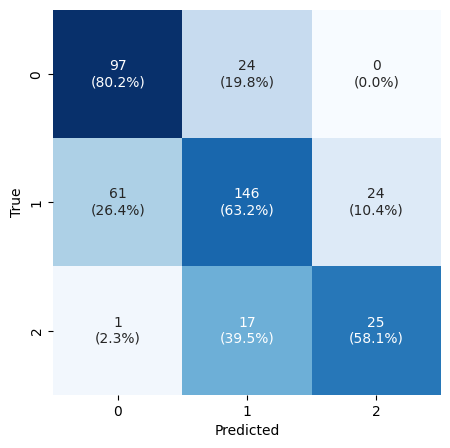

In [18]:
# Calculate the row percentages
row_sums = cm_test.sum(axis=1, keepdims=True)
cm_percentage = cm_test / row_sums * 100

# Create a custom annotation that includes both count and percentage
annotations = np.empty_like(cm_test).astype(str)

for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        annotations[i, j] = f'{cm_test[i, j]}\n({cm_percentage[i, j]:.1f}%)'

# Plot the heatmap with the annotations, using cm_percentage for the color mapping
plt.figure(figsize=(5, 5))
sns.heatmap(cm_percentage, annot=annotations, fmt='', cmap='Blues', cbar=False)
#plt.title('Confusion Matrix with Row Percentages')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [19]:
misclassified_indices = [i for i, (pred, label) in enumerate(zip(all_preds, all_labels)) if pred != label]

In [20]:
label_mapping

{'Alpha': 'Alpha',
 'Beta': 'Beta',
 'Beta-Delta': 'Beta',
 'Beta-Gamma': 'Beta-Gamma',
 'Beta-Gamma-Delta': 'Beta-Gamma',
 'Gamma': None,
 'Gamma-Delta': None}

In [21]:
test_df.iloc[8]

target_time.jd1                                                    2450656.0
target_time.jd2                                                         -0.5
datetime.jd1                                                       2450655.0
datetime.jd2                                                        0.499815
instrument                                                               MDI
path                       arccnet_data/02_intermediate/data/mag/fits/mdi...
processed_path_image       arccnet_data/03_processed/data/mag/fits/mdi/md...
target_time_arc.jd1                                                2450656.0
target_time_arc.jd2                                                     -0.5
datetime_arc.jd1                                                   2450655.0
datetime_arc.jd2                                                    0.499815
record_T_REC_arc                                     1997.07.26_00:00:00_TAI
path_arc                   arccnet_data/02_intermediate/data/mag/fits/mdi...

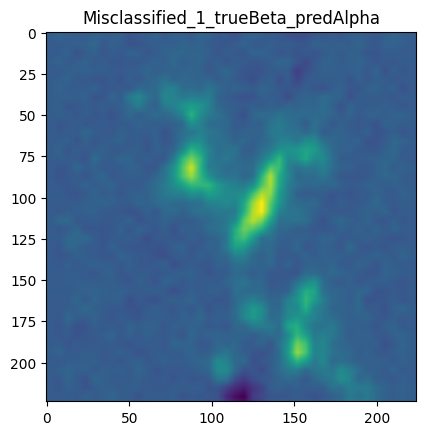

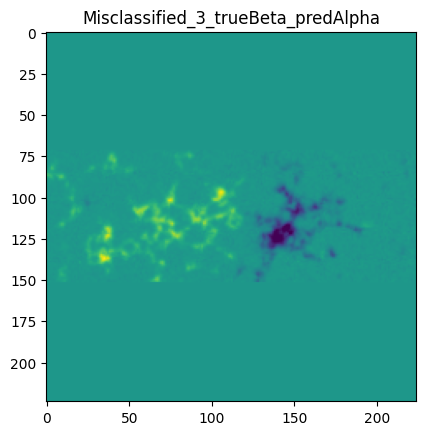

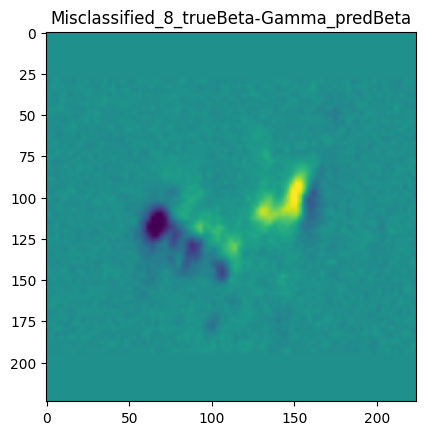

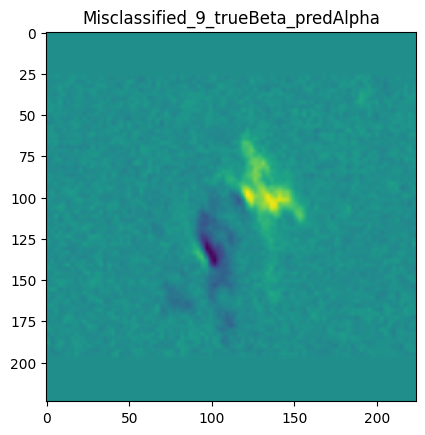

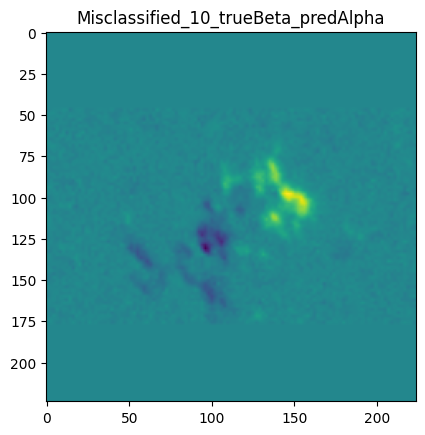

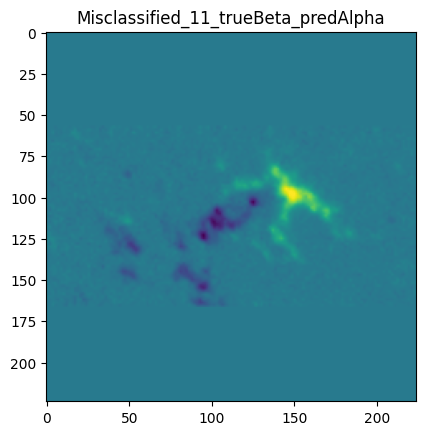

In [22]:
for idx in misclassified_indices[:6]:  # Log 20 misclassified examples
    img, true_label = test_dataset[idx]
    pred_label = all_preds[idx]
    plt.imshow(img.squeeze(0))
    plt.title(f"Misclassified_{idx}_true{label_encoder.classes_[int(true_label)]}_pred{label_encoder.classes_[int(pred_label)]}")
    plt.show()